In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

In [3]:
from TVA1_UU import TVA1_UU

In [4]:
bhdvcs = TVA1_UU()

In [8]:
data = pd.read_csv('dvcs_psuedo.csv')

# For Set 0

In [6]:
data = data.loc[(data['#Set'] == 0) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [11]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return interference

In [12]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [13]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

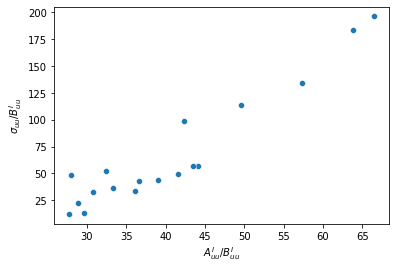

In [11]:
sns.scatterplot(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs))
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

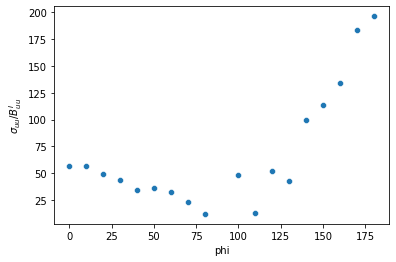

In [12]:
sns.scatterplot(x=data['phi_x'], y=produceLHS(data, bhdvcs))
plt.xlabel('phi')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.show()

In [13]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
err = produceLHSerr(data, bhdvcs)

In [14]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [15]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

### Fitted Compton Form Factors

In [16]:
cffs

array([ 14.54053928, -62.67604606])

In [17]:
np.diag(var)

array([ 2.76964485, 73.90142948])

### True CFFs

In [23]:
data.loc[0, ['ReH', 'ReE']]

ReH    13.0554
ReE   -53.0554
Name: 0, dtype: float64

In [24]:
yhat = linear_curve_fit(X, *cffs)
yhatupper = linear_curve_fit(X, *(cffs + np.diag(var)))
yhatlower = linear_curve_fit(X, *(cffs - np.diag(var)))

In [25]:
yhatwtrue = linear_curve_fit(X, 13.0554, -53.0554)

### Central Values

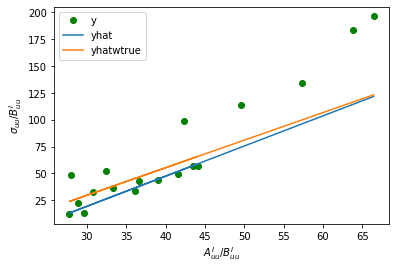

In [26]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from variance

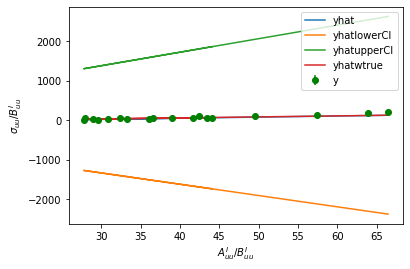

In [27]:
plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatlower, label='yhatlowerCI')
plt.plot(aoverb(data, bhdvcs), yhatupper, label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Limits

In [140]:
high = data.copy()
high['F'] = data['F'] + data['errF']
low = data.copy()
low['F'] = data['F'] - data['errF']

In [141]:
high

#Set  index           errF              F  phi_x       QQ       x_b  \
0       0      0   25081.524489   25138.168588      0  1.74013  0.435095   
1       0      1   26351.191492   26408.281825     10  1.74013  0.435095   
2       0      2   25735.520380   25784.978030     20  1.74013  0.435095   
3       0      3   27506.073129   27549.801901     30  1.74013  0.435095   
4       0      4   27565.719183   27599.769229     40  1.74013  0.435095   
..    ...    ...            ...            ...    ...      ...       ...   
535    14     31  205922.720357  205958.766365    310  2.63258  0.345012   
536    14     32  163100.166302  163138.850578    320  2.63258  0.345012   
537    14     33  166251.770829  166301.670076    330  2.63258  0.345012   
538    14     34  181674.765242  181739.540946    340  2.63258  0.345012   
539    14     35  165637.484194  165703.191995    350  2.63258  0.345012   

            t     k        F1       F2      dvcs      ReH      ReE  ReHtilde  
0   -0.380868  3.75  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
1   -0.380868  3.75  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
2   -0.380868  3.75  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
3   -0.380868  3.75  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
4   -0.380868  3.75  0.498060  0.68579  0.012288  13.0554 -53.0554   7.25302  
..        ...   ...       ...      ...       ...      ...      ...       ...  
535 -0.361188  7.75  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
536 -0.361188  7.75  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
537 -0.361188  7.75  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
538 -0.361188  7.75  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  
539 -0.361188  7.75  0.512913  0.71481  0.012288  11.7411 -51.7411   6.52283  

[540 rows x 15 columns]

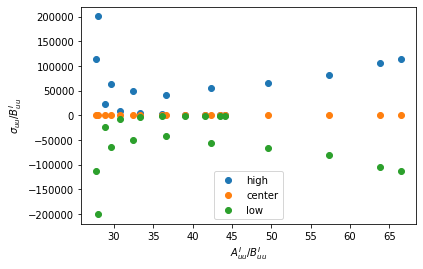

In [25]:
plt.scatter(x=aoverb(high, bhdvcs), y=produceLHS(high, bhdvcs), label='high')
plt.scatter(x=aoverb(data, bhdvcs), y=produceLHS(data, bhdvcs), label='center')
plt.scatter(x=aoverb(low, bhdvcs), y=produceLHS(low, bhdvcs), label='low')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## Error from limits

In [43]:
np.log10(1 + np.log10(1000000000))

1.0

$$\left[\frac{100000}{\sqrt{N_{\text{teammates}}}}\right]\left[\text{Rank}^{-0.75}\right]\left[\log_{10}( 1 + \log_{10}(N_{\text{teams}}))\right]\left[e^{-t/500}\right]$$

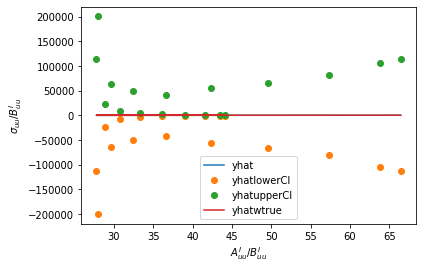

In [37]:
#plt.errorbar(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), yerr=err, fmt='go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(low, bhdvcs), produceLHS(low, bhdvcs), 'o', label='yhatlowerCI')
plt.plot(aoverb(high, bhdvcs), produceLHS(high, bhdvcs), 'o', label='yhatupperCI')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

## A/B vs phi

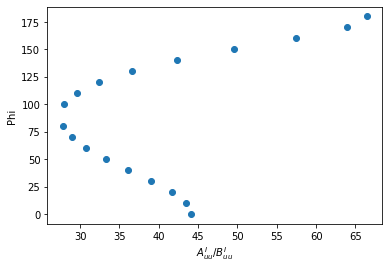

In [23]:
plt.scatter(aoverb(data, bhdvcs), data['phi_x'])
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('Phi')
plt.show()

# New Error

In [149]:
y = produceLHS(data, bhdvcs)

X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
high = data.copy()
high['F'] = data['F'] + data['errF']
err = np.abs(produceLHS(high, bhdvcs) - y)

In [152]:
err = produceLHSerr(data, bhdvcs)

In [60]:
cffs, var = optimize.curve_fit(linear_curve_fit, X, y, sigma=err)

In [61]:
cffs

array([-4.14998417, 30.11224422])

In [ ]:
plt.plot(aoverb(data, bhdvcs), produceLHS(data, bhdvcs), 'go', label='y')
plt.plot(aoverb(data, bhdvcs), yhat, label='yhat')
plt.plot(aoverb(data, bhdvcs), yhatwtrue, label='yhatwtrue')
plt.xlabel('$A_{uu}^I/B_{uu}^I$')
plt.ylabel('$\sigma_{uu}/B_{uu}^I$')
plt.legend()
plt.show()

# Simultaneous

In [38]:
import BHDVCStf

In [39]:
import utilities

In [103]:
def combined_function(data, ReH, ReE, ReHtilde):
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    y1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    y2 = linear_curve_fit(X, ReH, ReE)
    return np.array((y1 + y2)/2)

In [163]:
data = pd.read_csv('dvcs_psuedo.csv')

In [164]:
data['F'] = produceLHS(data, bhdvcs)

In [165]:
high = data.copy()
high['F'] = high['F'] + high['errF']
data['errF'] = np.abs(produceLHS(high, bhdvcs) - data['F'])

In [167]:
data['errF'].describe()

count    5.400000e+02
mean     1.771357e+23
std      1.110558e+24
min      2.478243e+01
25%      5.754376e+04
50%      1.466405e+05
75%      5.665330e+05
max      1.004347e+25
Name: errF, dtype: float64

In [108]:
combined_function(data, 1., 1., 20.)

array([ 14.27053015,  14.18726434,  13.97456414,  13.7323913 ,
        13.59776836,  13.72086449,  14.25384534,  15.35368962,
        17.19516441,  24.01063197,  29.61165748,  37.24188467,
        47.40651283,  60.49420681,  76.30235026,  93.13221648,
       106.95007874, 112.4407308 ])

In [126]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
        replicas = []
        #X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        #sigma = seti.erry 
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            #y = seti.sampleY()
            cff, cffcov = optimize.curve_fit(combined_function, seti, seti['F'], pars, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [127]:
results = produceResults(data, 15, 1)

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


In [130]:
import utilities as uts

In [133]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 0)

Mean percent error:  28.10510889888377
RMSE:  3.467259854776928
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -0.884910856650496


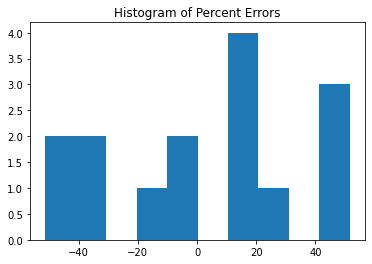

In [135]:
uts.evaluate(y_yhat)

In [136]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 1)

Mean percent error:  30.48759203241225
RMSE:  19.741552613266293
RMSE w yhat=mean:  2.525480507907797
R-squared:  -60.104693417140794


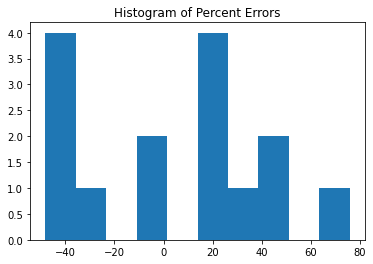

In [137]:
uts.evaluate(y_yhat)

In [138]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 2)

Mean percent error:  49.65253896508765
RMSE:  7.249909738406301
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -25.701057391692828


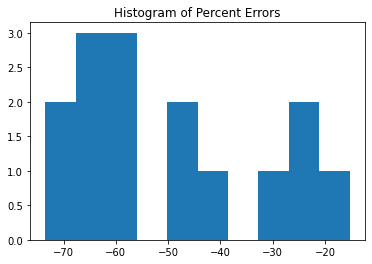

In [139]:
uts.evaluate(y_yhat)

# Optimize by average Chi-square

In [32]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [38]:
data = pd.read_csv('dvcs_May21.csv')
data = data.loc[(data['#Set'] == 1) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [39]:
x0 = np.array([1, 1, 1])
optimize.minimize(combined_function_chisq, x0, args=data)

      fun: 972.3773378842739
 hess_inv: array([[ 1.14446414e-09, -6.13724596e-09,  4.97406431e-09],
       [-6.13724596e-09,  5.32002090e-08, -4.69106791e-08],
       [ 4.97406431e-09, -4.69106791e-08,  4.18039318e-08]])
      jac: array([ 0.02075195, -0.00143433,  0.012146  ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 347
      nit: 9
     njev: 67
   status: 2
  success: False
        x: array([-0.0113396 ,  0.07567396, -0.00141167])

# Redo

In [86]:
import utilities as uts
from tqdm import tqdm

In [87]:
def produceLHS(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    interference = data['F'] - data['dvcs'] - bh
    interference /= bhdvcs.Gamma
    interference *= data['QQ']
    interference *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    interference /= b
    return -interference

In [88]:
def produceLHSerr(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    err = data['errF']
    err /= bhdvcs.Gamma
    err *= data['QQ']
    err *= np.abs(data['t'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    err /= b
    return np.abs(err)

In [89]:
def aoverb(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    return a/b

In [90]:
def linear_curve_fit(data, ReH, ReE):
    bhdvcs.SetKinematics(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
    a, b = bhdvcs.ABcon(data[:, 4], data[:, 5], data[:, 6])
    #tau = -data['t']/(4*bhdvcs.M2)
    gm = data[:, 5] + data[:, 6]
    return (a/b)*(data[:, 5]*ReH + bhdvcs.tau*data[:, 6]*ReE) + gm*(ReH + ReE)

In [91]:
def combined_function_chisq(cffs, data):
    ReH, ReE, ReHtilde = cffs
    dftu = data.copy()
    dftu['F'] = bhdvcs.TotalUUXS(np.array(data[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]), ReH, ReE, ReHtilde)
    yhat1 = produceLHS(dftu, bhdvcs)
    X = np.array(data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])
    yhat2 = linear_curve_fit(X, ReH, ReE)
    chisq1 = np.sum(((yhat1 - data['F'])/data['errF'])**2)
    chisq2 = np.sum(((yhat2 - data['F'])/data['errF'])**2)
    return (chisq1 + chisq2)/2

In [120]:
data = pd.read_csv('dvcs_May21.csv')
data['dvcs'] = .0214549

In [100]:
high = data.copy()
high['F'] = high['F'] + high['sigmaF']
data['sigmaF'] = np.abs(produceLHS(high, bhdvcs) - produceLHS(data, bhdvcs))

In [101]:
data['F'] = produceLHS(data, bhdvcs)

# Test line_func

In [130]:
def testFunc(data, bhdvcs):
    bhdvcs.SetKinematics(data['QQ'], data['x_b'], data['t'], data['k'])
    bh = bhdvcs.GetBHUUxs(data['phi_x'], data['F1'], data['F2'])
    return bh
    #interference = data['F'] - data['dvcs'] - bh
    #interference /= bhdvcs.Gamma
    #interference *= data['QQ']
    #interference *= np.abs(data['t'])
    #a, b = bhdvcs.ABcon(data['phi_x'], data['F1'], data['F2'])
    #interference /= b
    return interference

In [125]:
data['F'][0]

4.193969999999999

In [132]:
testFunc(data, bhdvcs)[9]

<tf.Tensor: shape=(), dtype=float64, numpy=0.22370848360156267>

In [117]:
data.loc[data['#Set'] == 1, :]

#Set  index     k       QQ       x_b         t  phi_x         F    sigmaF  \
0      1      0  2.75  1.51576  0.369204 -0.306885      8  4.193970  0.209699   
1      1      1  2.75  1.51576  0.369204 -0.306885     16  2.950900  0.147545   
2      1      2  2.75  1.51576  0.369204 -0.306885     24  1.865680  0.093284   
3      1      3  2.75  1.51576  0.369204 -0.306885     32  1.139000  0.056950   
4      1      4  2.75  1.51576  0.369204 -0.306885     40  0.871079  0.043554   
5      1      5  2.75  1.51576  0.369204 -0.306885     48  0.640750  0.032037   
6      1      6  2.75  1.51576  0.369204 -0.306885     56  0.474527  0.023726   
7      1      7  2.75  1.51576  0.369204 -0.306885     64  0.391808  0.019590   
8      1      8  2.75  1.51576  0.369204 -0.306885     72  0.293337  0.014667   
9      1      9  2.75  1.51576  0.369204 -0.306885     80  0.256715  0.012836   
10     1     10  2.75  1.51576  0.369204 -0.306885     88  0.204206  0.010210   
11     1     11  2.75  1.51576  0.369204 -0.306885     96  0.182541  0.009127   
12     1     12  2.75  1.51576  0.369204 -0.306885    104  0.160291  0.008015   
13     1     13  2.75  1.51576  0.369204 -0.306885    112  0.130988  0.006549   
14     1     14  2.75  1.51576  0.369204 -0.306885    120  0.134580  0.006729   
15     1     15  2.75  1.51576  0.369204 -0.306885    128  0.114819  0.005741   
16     1     16  2.75  1.51576  0.369204 -0.306885    136  0.107080  0.005354   
17     1     17  2.75  1.51576  0.369204 -0.306885    144  0.101558  0.005078   
18     1     18  2.75  1.51576  0.369204 -0.306885    152  0.093940  0.004697   
19     1     19  2.75  1.51576  0.369204 -0.306885    160  0.091902  0.004595   
20     1     20  2.75  1.51576  0.369204 -0.306885    168  0.094242  0.004712   
21     1     21  2.75  1.51576  0.369204 -0.306885    176  0.093330  0.004667   
22     1     22  2.75  1.51576  0.369204 -0.306885    184  0.090850  0.004542   
23     1     23  2.75  1.51576  0.369204 -0.306885    192  0.086071  0.004304   
24     1     24  2.75  1.51576  0.369204 -0.306885    200  0.102205  0.005110   
25     1     25  2.75  1.51576  0.369204 -0.306885    208  0.105005  0.005250   
26     1     26  2.75  1.51576  0.369204 -0.306885    216  0.096090  0.004804   
27     1     27  2.75  1.51576  0.369204 -0.306885    224  0.105889  0.005294   
28     1     28  2.75  1.51576  0.369204 -0.306885    232  0.118959  0.005948   
29     1     29  2.75  1.51576  0.369204 -0.306885    240  0.119264  0.005963   
30     1     30  2.75  1.51576  0.369204 -0.306885    248  0.131332  0.006567   
31     1     31  2.75  1.51576  0.369204 -0.306885    256  0.154156  0.007708   
32     1     32  2.75  1.51576  0.369204 -0.306885    264  0.176926  0.008846   
33     1     33  2.75  1.51576  0.369204 -0.306885    272  0.201732  0.010087   
34     1     34  2.75  1.51576  0.369204 -0.306885    280  0.244551  0.012228   
35     1     35  2.75  1.51576  0.369204 -0.306885    288  0.313552  0.015678   
36     1     36  2.75  1.51576  0.369204 -0.306885    296  0.385957  0.019298   
37     1     37  2.75  1.51576  0.369204 -0.306885    304  0.443805  0.022190   
38     1     38  2.75  1.51576  0.369204 -0.306885    312  0.653683  0.032684   
39     1     39  2.75  1.51576  0.369204 -0.306885    320  0.861213  0.043061   
40     1     40  2.75  1.51576  0.369204 -0.306885    328  1.234500  0.061725   
41     1     41  2.75  1.51576  0.369204 -0.306885    336  1.748280  0.087414   
42     1     42  2.75  1.51576  0.369204 -0.306885    344  2.903570  0.145179   
43     1     43  2.75  1.51576  0.369204 -0.306885    352  3.997470  0.199873   
44     1     44  2.75  1.51576  0.369204 -0.306885    360  4.696610  0.234831   

    varF        F1        F2      dvcs  
0   0.05  0.542867  0.798677  0.021455  
1   0.05  0.542867  0.798677  0.021455  
2   0.05  0.542867  0.798677  0.021455  
3   0.05  0.542867  0.798677  0.021455  
4   0.05  0.542867  0.798677  0.021455  
5   0.05  0.542867  0.798677  0

In [27]:
test_data

#Set  index     k       QQ       x_b         t  phi_x            F  \
0      1      0  2.75  1.51576  0.369204 -0.306885      8    36.339168   
1      1      1  2.75  1.51576  0.369204 -0.306885     16    45.923806   
2      1      2  2.75  1.51576  0.369204 -0.306885     24    26.702937   
3      1      3  2.75  1.51576  0.369204 -0.306885     32   -31.252933   
4      1      4  2.75  1.51576  0.369204 -0.306885     40    23.302559   
5      1      5  2.75  1.51576  0.369204 -0.306885     48    34.108732   
6      1      6  2.75  1.51576  0.369204 -0.306885     56    11.514802   
7      1      7  2.75  1.51576  0.369204 -0.306885     64   142.308617   
8      1      8  2.75  1.51576  0.369204 -0.306885     72   -49.572514   
9      1      9  2.75  1.51576  0.369204 -0.306885     80   668.405985   
10     1     10  2.75  1.51576  0.369204 -0.306885     88 -2043.991718   
11     1     11  2.75  1.51576  0.369204 -0.306885     96  1102.818110   
12     1     12  2.75  1.51576  0.369204 -0.306885    104   219.808059   
13     1     13  2.75  1.51576  0.369204 -0.306885    112   -82.868009   
14     1     14  2.75  1.51576  0.369204 -0.306885    120    95.217473   
15     1     15  2.75  1.51576  0.369204 -0.306885    128    11.801759   
16     1     16  2.75  1.51576  0.369204 -0.306885    136    10.186088   
17     1     17  2.75  1.51576  0.369204 -0.306885    144    10.231182   
18     1     18  2.75  1.51576  0.369204 -0.306885    152     0.821612   
19     1     19  2.75  1.51576  0.369204 -0.306885    160     3.648590   
20     1     20  2.75  1.51576  0.369204 -0.306885    168    12.704438   
21     1     21  2.75  1.51576  0.369204 -0.306885    176    12.440487   

          sigmaF  varF        F1        F2     dvcs  
0      23.613865  0.05  0.542867  0.798677  0.02066  
1      25.609226  0.05  0.542867  0.798677  0.02066  
2      27.444269  0.05  0.542867  0.798677  0.02066  
3      29.124589  0.05  0.542867  0.798677  0.02066  
4      39.183723  0.05  0.542867  0.798677  0.02066  
5      51.778680  0.05  0.542867  0.798677  0.02066  
6      71.885612  0.05  0.542867  0.798677  0.02066  
7     120.881846  0.05  0.542867  0.798677  0.02066  
8     218.175000  0.05  0.542867  0.798677  0.02066  
9     694.872138  0.05  0.542867  0.798677  0.02066  
10  15144.173547  0.05  0.542867  0.798677  0.02066  
11   1616.791569  0.05  0.542867  0.798677  0.02066  
12    276.610821  0.05  0.542867  0.798677  0.02066  
13     96.438715  0.05  0.542867  0.798677  0.02066  
14     56.088109  0.05  0.542867  0.798677  0.02066  
15     31.530583  0.05  0.542867  0.798677  0.02066  
16     21.399953  0.05  0.542867  0.798677  0.02066  
17     15.900983  0.05  0.542867  0.798677  0.02066  
18     12.231990  0.05  0.542867  0.798677  0.02066  
19     10.477950  0.05  0.542867  0.798677  0.02066  
20      9.856582  0.05  0.542867  0.798677  0.02066  
21      9.355171  0.05  0.542867  0.798677  0.02066

In [30]:
linear_curve_fit(X, 1, 1)

<tf.Tensor: shape=(22,), dtype=float64, numpy=
array([-9.15525897, -9.1594554 , -9.15785446, -9.13838875, -9.086011  ,
       -8.98484205, -8.82098916, -8.58556474, -8.27710506, -7.90255377,
       -7.47638268, -7.01811658, -6.54911275, -6.08958874, -5.65658714,
       -5.26307641, -4.91799609, -4.62688489, -4.39274576, -4.21690571,
       -4.09973958, -4.04120857])>

## Set 1

In [66]:
test_data

#Set  index     k       QQ       x_b         t  phi_x            F  \
0      1      0  2.75  1.51576  0.369204 -0.306885      8   -36.339168   
1      1      1  2.75  1.51576  0.369204 -0.306885     16   -45.923806   
2      1      2  2.75  1.51576  0.369204 -0.306885     24   -26.702937   
3      1      3  2.75  1.51576  0.369204 -0.306885     32    31.252933   
4      1      4  2.75  1.51576  0.369204 -0.306885     40   -23.302559   
5      1      5  2.75  1.51576  0.369204 -0.306885     48   -34.108732   
6      1      6  2.75  1.51576  0.369204 -0.306885     56   -11.514802   
7      1      7  2.75  1.51576  0.369204 -0.306885     64  -142.308617   
8      1      8  2.75  1.51576  0.369204 -0.306885     72    49.572514   
9      1      9  2.75  1.51576  0.369204 -0.306885     80  -668.405985   
10     1     10  2.75  1.51576  0.369204 -0.306885     88  2043.991718   
11     1     11  2.75  1.51576  0.369204 -0.306885     96 -1102.818110   
12     1     12  2.75  1.51576  0.369204 -0.306885    104  -219.808059   
13     1     13  2.75  1.51576  0.369204 -0.306885    112    82.868009   
14     1     14  2.75  1.51576  0.369204 -0.306885    120   -95.217473   
15     1     15  2.75  1.51576  0.369204 -0.306885    128   -11.801759   
16     1     16  2.75  1.51576  0.369204 -0.306885    136   -10.186088   
17     1     17  2.75  1.51576  0.369204 -0.306885    144   -10.231182   
18     1     18  2.75  1.51576  0.369204 -0.306885    152    -0.821612   
19     1     19  2.75  1.51576  0.369204 -0.306885    160    -3.648590   
20     1     20  2.75  1.51576  0.369204 -0.306885    168   -12.704438   
21     1     21  2.75  1.51576  0.369204 -0.306885    176   -12.440487   

          sigmaF  varF        F1        F2      dvcs  
0      23.613865  0.05  0.542867  0.798677  0.021455  
1      25.609226  0.05  0.542867  0.798677  0.021455  
2      27.444269  0.05  0.542867  0.798677  0.021455  
3      29.124589  0.05  0.542867  0.798677  0.021455  
4      39.183723  0.05  0.542867  0.798677  0.021455  
5      51.778680  0.05  0.542867  0.798677  0.021455  
6      71.885612  0.05  0.542867  0.798677  0.021455  
7     120.881846  0.05  0.542867  0.798677  0.021455  
8     218.175000  0.05  0.542867  0.798677  0.021455  
9     694.872138  0.05  0.542867  0.798677  0.021455  
10  15144.173547  0.05  0.542867  0.798677  0.021455  
11   1616.791569  0.05  0.542867  0.798677  0.021455  
12    276.610821  0.05  0.542867  0.798677  0.021455  
13     96.438715  0.05  0.542867  0.798677  0.021455  
14     56.088109  0.05  0.542867  0.798677  0.021455  
15     31.530583  0.05  0.542867  0.798677  0.021455  
16     21.399953  0.05  0.542867  0.798677  0.021455  
17     15.900983  0.05  0.542867  0.798677  0.021455  
18     12.231990  0.05  0.542867  0.798677  0.021455  
19     10.477950  0.05  0.542867  0.798677  0.021455  
20      9.856582  0.05  0.542867  0.798677  0.021455  
21      9.355171  0.05  0.542867  0.798677  0.021455

In [62]:
aoverb(test_data, bhdvcs)

<tf.Tensor: shape=(22,), dtype=float64, numpy=
array([-20.80195524, -21.30862769, -22.13153793, -23.2291729 ,
       -24.52719389, -25.90902055, -27.21621668, -28.26769937,
       -28.89965814, -29.01287531, -28.6026257 , -27.75346406,
       -26.60399241, -25.30362857, -23.98112311, -22.73116336,
       -21.61482861, -20.66675079, -19.90364523, -19.33159246,
       -18.95133238, -18.76171678])>

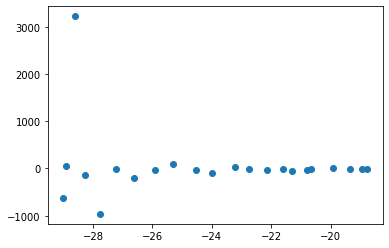

In [72]:
plt.scatter(aoverb(test_data, bhdvcs), test_data['F'])

In [70]:
test_data = data.loc[(data['#Set'] == 1) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [71]:
X = np.array(test_data[['QQ', 'x_b', 't', 'k', 'phi_x', 'F1', 'F2']])

In [17]:
res = optimize.curve_fit(linear_curve_fit, X, test_data['F'])

In [18]:
res[0]

array([ -4.12792886, 112.58239293])

## Set 2

In [123]:
test_data = data.loc[(data['#Set'] == 1) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]

In [124]:
x0 = np.array([1, 1, 1])
res = optimize.minimize(combined_function_chisq, x0, args=test_data)

In [125]:
res.x

array([  22.80075777, -106.27311581,    3.14101246])

In [126]:
np.diag(res.hess_inv)

array([ 2.65185418, 72.37910705,  1.18399464])

In [100]:
seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
rep_data = seti.copy()
rep_data['F'] = np.random.normal(rep_data['F'], rep_data['errF'])

In [101]:
rep_data

#Set  index       errF          F  phi_x       QQ       x_b         t  \
72     2      0   7.386159 -36.449778      0  2.17955  0.385579 -0.283318   
73     2      1   7.308711 -48.273208     10  2.17955  0.385579 -0.283318   
74     2      2   7.293302 -23.867232     20  2.17955  0.385579 -0.283318   
75     2      3   7.917898 -24.454727     30  2.17955  0.385579 -0.283318   
76     2      4   8.741887 -36.001161     40  2.17955  0.385579 -0.283318   
77     2      5   9.778452 -36.725486     50  2.17955  0.385579 -0.283318   
78     2      6  11.226435 -31.586213     60  2.17955  0.385579 -0.283318   
79     2      7  16.054382 -30.243423     70  2.17955  0.385579 -0.283318   
80     2      8  31.530305 -78.905321     80  2.17955  0.385579 -0.283318   
82     2     10  26.400642 -78.402304    100  2.17955  0.385579 -0.283318   
83     2     11  13.160113 -49.924246    110  2.17955  0.385579 -0.283318   
84     2     12   9.930851 -15.479205    120  2.17955  0.385579 -0.283318   
85     2     13   8.921047   2.594373    130  2.17955  0.385579 -0.283318   
86     2     14   7.856242 -15.990681    140  2.17955  0.385579 -0.283318   
87     2     15   7.545726   1.063319    150  2.17955  0.385579 -0.283318   
88     2     16   7.377073  -6.603620    160  2.17955  0.385579 -0.283318   
89     2     17   7.849760   3.183050    170  2.17955  0.385579 -0.283318   
90     2     18   7.912504   0.594784    180  2.17955  0.385579 -0.283318   

       k        F1        F2      dvcs      ReH      ReE  ReHtilde  
72  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
73  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
74  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
75  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
76  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
77  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
78  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
79  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
80  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
82  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
83  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
84  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
85  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
86  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
87  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
88  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
89  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347  
90  4.75  0.579414  0.848208  0.012288  7.22424 -47.2242   4.01347

In [108]:
np.array([, np.random.normal(res.x, np.diag(res.hess_inv), size=(10, 3))])

array([[[  19.89816508,  -88.34121367,    4.16433741],
        [  25.51979272, -115.75732595,    4.59676969],
        [  23.56839302,  -72.88467036,    2.53200944],
        [  26.86312547,  -91.74153215,    3.46497155],
        [  20.73871708, -287.54265193,    3.57678543],
        [  24.01563157,    1.20282739,    3.06943454],
        [  21.69141536, -140.09653075,    4.24545324],
        [  22.65614068,  -77.97815981,    3.91353327],
        [  22.59310269,  -99.92002087,    2.71104807],
        [  18.50843565, -197.46597487,    4.00077812]],

       [[  20.62384541, -160.63609382,    1.19334125],
        [  26.99151647,   23.83793832,    3.50546693],
        [  23.67283548, -115.75091353,    3.94521585],
        [  19.53855812, -152.97019707,    2.45278248],
        [  23.23834906,   34.35692924,    3.90016106],
        [  21.72492143, -142.7226738 ,    3.89953589],
        [  24.27088822,   -3.68752385,    0.76589982],
        [  24.34931396, -256.00170037,    0.90076853],
        

In [136]:
def produceResults(data, numSets, numReplicas):
    '''
    :param data: data of class DvcsData (which can be found in utilities.py)
    :param numSets: number of different kinematic sets contained in data
    :param numReplicas: number of replicas you would like to produce
    
    :returns: numpy array with shape (numSets, numReplicas, numCFFs)
    '''
    results = []
    for i in tqdm(range(numSets)):
        seti = data.loc[(data['#Set'] == i) & (data['phi_x'] <= 180) & (data['phi_x'] != 90), :]
        replicas = []
        #X = np.array(seti.XnoCFF) # the kinematics and all variables necessary to compute 
        #sigma = seti.erry 
        pars = np.array([1, 1, 1])
        optobj = optimize.minimize(combined_function_chisq, x0, args=seti)
        results.append(np.random.normal(res.x, np.diag(res.hess_inv), size=(numReplicas, 3)))
    return np.array(results)

In [110]:
results = produceResults(data, 15, 10)

100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


In [115]:
localFits = np.fromfile('replicas500.txt')
localFits = localFits.reshape(15, 500, 3)

## ReH

Mean percent error:  57.56907125751066
RMSE:  13.261677918395833
RMSE w yhat=mean:  2.5254628436780107
R-squared:  -26.574966009710646


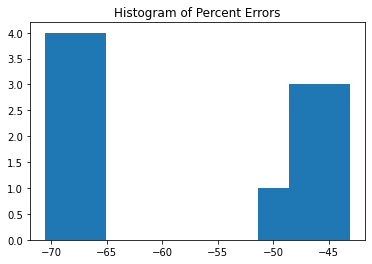

In [116]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 0)
uts.evaluate(y_yhat)

In [127]:
y_yhatlocal, errlocal = uts.y_yhat_errCFFs(uts.DvcsData(data), localFits, 0)

In [128]:
def plotError(y_yhat, orig_y, errs, orig_err, var_string, title=None):
    '''
    :param y_yhat: numpy array of what it sounds like
    :param errs: list or array of stds of variable
    :param var_string: string of which variable is being plotted
    '''
    assert len(y_yhat) == len(errs)
    
    fig, ax = plt.subplots()
    ax.errorbar(x=list(range(len(errs))),
                 y=list(map(lambda x: x[1], y_yhat)),
                yerr=errs,
                fmt='o',
                label="Estimated " + var_string)
    ax.plot(list(range(len(errs))),
             list(map(lambda x: x[0], y_yhat)),
             'ro', label="Actual " + var_string)
    
    ax.errorbar(x=list(range(len(orig_err))),
             y=list(map(lambda x: x[1], orig_y)),
            yerr=errs,
            fmt='o',
            label="Baseline " + var_string)
    
    ax.set_xlabel("Set#")
    ax.set_ylabel(var_string)
    if title != None:
        ax.set_title(title)
        
    ax.legend()
    
    plt.show()

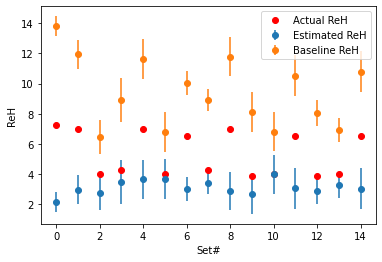

In [129]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReH')

## ReE

Mean percent error:  51.38145231181199
RMSE:  59.22706436860226
RMSE w yhat=mean:  2.525480507907797
R-squared:  -548.9869342579308


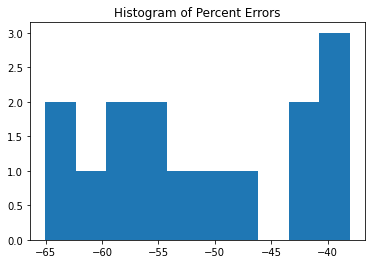

In [130]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 1)
uts.evaluate(y_yhat)

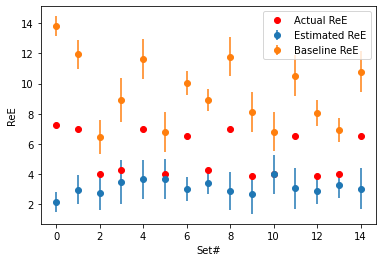

In [135]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReE')

## ReHtilde

Mean percent error:  77.53068591303303
RMSE:  2.7441047078320144
RMSE w yhat=mean:  1.4030345621243816
R-squared:  -2.8252922340236393


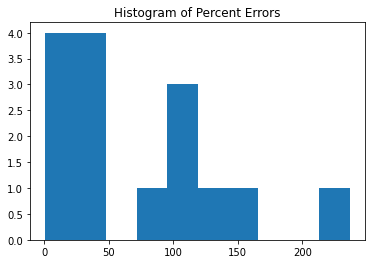

In [132]:
y_yhat, err = uts.y_yhat_errCFFs(uts.DvcsData(data), results, 2)
uts.evaluate(y_yhat)

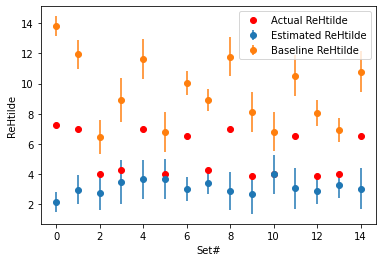

In [134]:
plotError(y_yhat, y_yhatlocal, err, errlocal, 'ReHtilde')